In [1]:
import sys
sys.path.append(r'../')
import numpy as np
from functions import *
import os
os.chdir("..")

# PCA

In [2]:
algorithm = 'PCA_time_delay_embedding'

worm_num = 0
### Load Data (and excluding behavioural neurons)
b_neurons = [
    'AVAR',
    'AVAL',
    'SMDVR',
    'SMDVL',
    'SMDDR',
    'SMDDL',
    'RIBR',
    'RIBL', ]
data = Database(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states
state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reversal', 'Slowing',
               'Ventral turn']

### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)
print(X_.shape, B_.shape)

(3122, 2, 15, 103) (3122,)


In [3]:
## Train test split
X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
X0_tr = X_train[:,0,:,:].reshape(X_train.shape[0], -1)
X1_tr = X_train[:,1,:,:].reshape(X_train.shape[0], -1)
X0_tst = X_test[:,0,:,:].reshape(X_test.shape[0], -1)
X1_tst = X_test[:,1,:,:].reshape(X_test.shape[0], -1)
print(X0_tr.shape, X1_tst.shape)

(2676, 1545) (446, 1545)


In [4]:
### Deploy PCA
dim = 3
pca = PCA(n_components=dim)
pca.fit(X0_tr)
print('Percentage of variance explained by the first ', dim, ' PCs: ',
      pca.explained_variance_ratio_[:dim].sum().round(3))

### Projecting into latent space
Y0_tr = pca.transform(X0_tr)
Y1_tr = pca.transform(X1_tr)

Y0_tst = pca.transform(X0_tst)
Y1_tst = pca.transform(X1_tst)

print(Y0_tr.shape, Y0_tst.shape)

Percentage of variance explained by the first  3  PCs:  0.747
(2676, 3) (446, 3)


/Users/aksheykumar/Desktop/comparison-algorithms/c_elegans_embedding_evaluation/functions.py:575: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[:,0], Y[:,1], Y[:,2], c='k', s=1, cmap = ListedColormap(colors))


(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

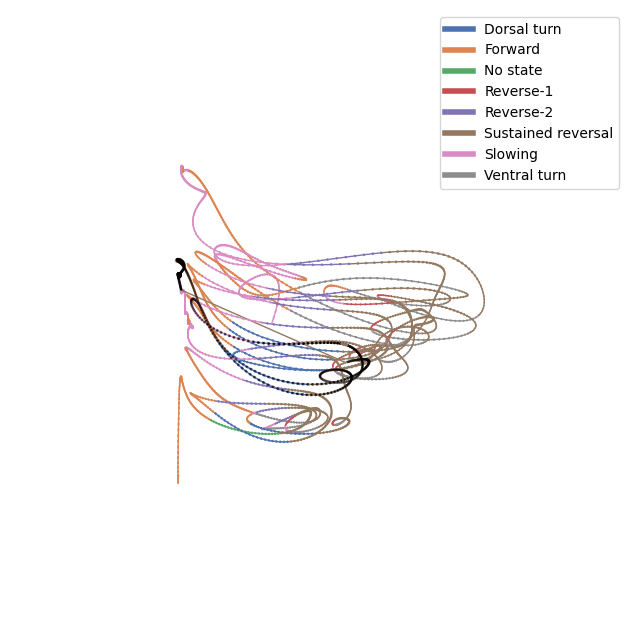

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
plot_ps_(fig, ax, Y=Y0_tr, B=B_train_1, state_names=state_names, show_points=False)
plot_ps_(fig, ax, Y=Y0_tst, B=B_test_1, state_names=state_names, show_points=True)



# Autoencoder

In [6]:
### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)

## Train test split
X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
X0_tr = X_train[:, 0, :, :]
X1_tr = X_train[:, 1, :, :]
X0_tst = X_test[:, 0, :, :]
X1_tst = X_test[:, 1, :, :]

### Autoencoder architecture
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(50, activation='relu'),
            layers.Dense(30, activation='relu'),
            layers.Dense(25, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dense(latent_dim, activation='linear'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dense(25, activation='relu'),
            layers.Dense(30, activation='relu'),
            layers.Dense(50, activation='relu'),
            layers.Dense(X0_tr.shape[-1] * X0_tr.shape[-2], activation='linear'),
            layers.Reshape(X0_tr.shape[1:])
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Deploy Autoencoder
autoencoder = Autoencoder(latent_dim=3)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse', metrics=['mse'])

history = autoencoder.fit(X0_tr,
                          X0_tr,
                          epochs=150,
                          batch_size=100,
                          validation_data=(X0_tst, X0_tst),
                          verbose=False
                          )

X0_pred = autoencoder(X0_tst).numpy()
modelmse_tst = mean_squared_error(flat_partial(X0_tst), flat_partial(X0_pred))
print('Test set mse:', modelmse_tst.round(8))


### Projecting into latent space
Y0_tr = autoencoder.encoder(X0_tr).numpy()
Y1_tr = autoencoder.encoder(X1_tr).numpy()

Y0_tst = autoencoder.encoder(X0_tst).numpy()
Y1_tst = autoencoder.encoder(X1_tst).numpy()


Test set mse: 0.00456265


/Users/aksheykumar/Desktop/comparison-algorithms/c_elegans_embedding_evaluation/functions.py:575: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[:,0], Y[:,1], Y[:,2], c='k', s=1, cmap = ListedColormap(colors))


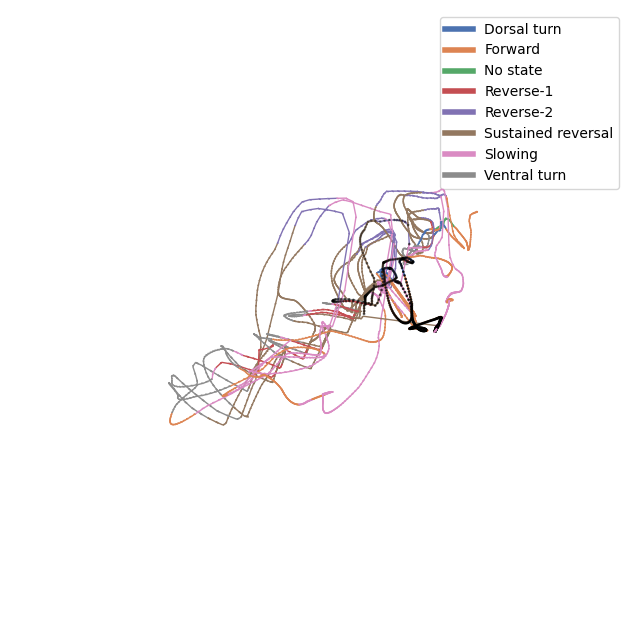

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
plot_ps_(fig, ax, Y=Y0_tr, B=B_train_1, state_names=state_names, show_points=False)
plot_ps_(fig, ax, Y=Y0_tst, B=B_test_1, state_names=state_names, show_points=True)
plt.show()


# LDA

In [18]:
### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)

## Train test split 
X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
print(X_train.shape, X_test.shape)
X0_tr = X_train[:,0,:,:].reshape(X_train.shape[0], -1)
X1_tr = X_train[:,1,:,:].reshape(X_train.shape[0], -1)
X0_tst = X_test[:,0,:,:].reshape(X_test.shape[0], -1)
X1_tst = X_test[:,1,:,:].reshape(X_test.shape[0], -1)
print(X0_tr.shape, X0_tst.shape)

### Deploy LDA
dim = 3
lda = LinearDiscriminantAnalysis(n_components=dim)
lda.fit(X0_tr, B_train_1)
print('Accuracy of LDA on train data', lda.score(X0_tr, B_train_1))
print('Accuracy of LDA on test data', lda.score(X0_tst, B_test_1))	

### Projecting into latent space
Y0_tr = lda.transform(X0_tr)
Y1_tr = lda.transform(X1_tr)

Y0_tst = lda.transform(X0_tst)
Y1_tst = lda.transform(X1_tst)


(2676, 2, 15, 103) (446, 2, 15, 103)
(2676, 1545) (446, 1545)
Accuracy of LDA on train data 0.9387144992526159
Accuracy of LDA on test data 0.273542600896861


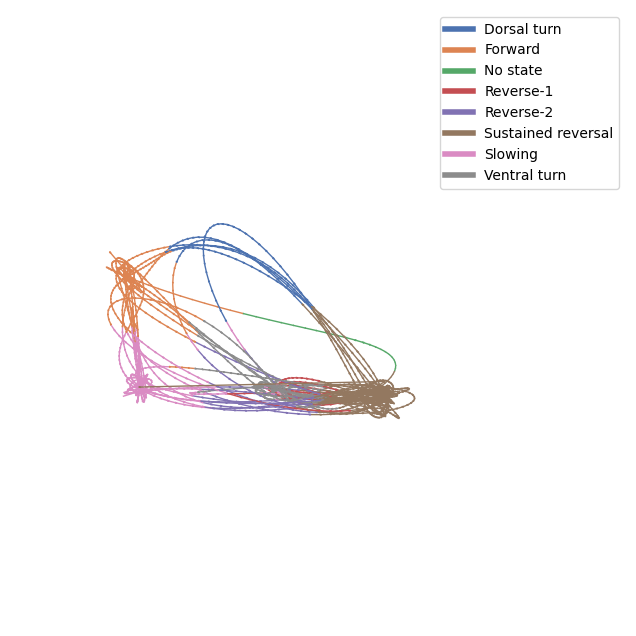

In [19]:
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
plot_ps_(fig, ax, Y=Y0_tr, B=B_train_1, state_names=state_names, show_points=False)
# plot_ps_(fig, ax, Y=Y0_tst, B=B_test_1, state_names=state_names, show_points=True)
plt.show()


# CEBRA

In [21]:
from cebra import CEBRA

In [ ]:

### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=1)

## Train test split 
X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
X0_tr = X_train[:, 0, :, :].reshape(X_train.shape[0], -1)
X1_tr = X_train[:, 1, :, :].reshape(X_train.shape[0], -1)
X0_tst = X_test[:, 0, :, :].reshape(X_test.shape[0], -1)
X1_tst = X_test[:, 1, :, :].reshape(X_test.shape[0], -1)

### Deploy CEBRA hybrid
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=5000,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10,
                    hybrid = True)

cebra_hybrid_model.fit(X0_tr, B_train_1.astype(float))
print(worm_num)

### Projecting into latent space
Y0_tr = cebra_hybrid_model.transform(X0_tr)
Y1_tr = cebra_hybrid_model.transform(X1_tr)

Y0_tst = cebra_hybrid_model.transform(X0_tst)
Y1_tst = cebra_hybrid_model.transform(X1_tst)


behavior_pos:  0.4700 behavior_neg:  5.4212 behav